In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [3]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [4]:
from models.CRNN import CRNN_model

# 1. Data

In [5]:
strategy = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy.load_index_and_return(from_db=False, save_file=False)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

strategy.ret.loc['2005-02-16'] = strategy.ret.loc['2005-02-17']

df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

2019-10-31 08:56:27,497 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 08:56:27,500 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 08:56:27,501 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


# 2. Explore

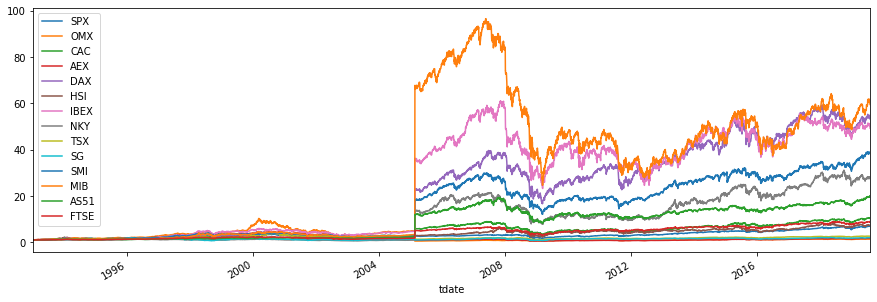

In [6]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

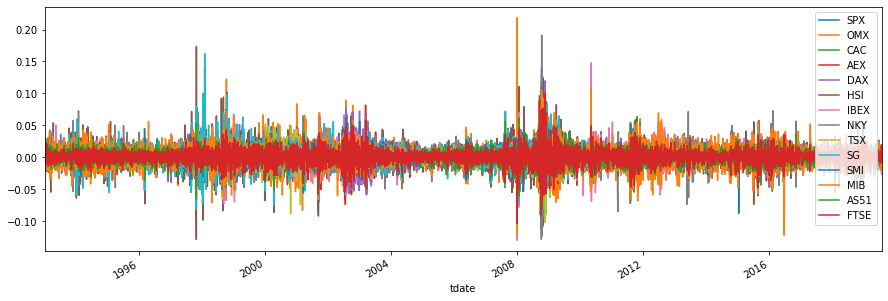

In [7]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

### CROSS SECTIONAL

In [8]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 189, 252]

## 1. X

### moving average 와 주가 차이

In [9]:
moving_avg = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg['moving_average_' + str(period)] = df_index.rolling(period).mean() - df_index

### moving average  ratio

In [10]:
moving_avg_ratio = {}
moving_avg_ratio_diff = {}

for i, period in enumerate(indiv_momentum_lst):
    moving_avg_ratio['moving_average_ratio_' + str(period)] = df_index.rolling(period).mean() / df_index
    moving_avg_ratio_diff['moving_average_ratio_diff_' + str(period)] = moving_avg_ratio['moving_average_ratio_' + str(period)].diff(period)

In [11]:
df_moving_avg = pd.concat(moving_avg, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio = pd.concat(moving_avg_ratio, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_moving_avg_ratio_diff = pd.concat(moving_avg_ratio_diff, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

### moving average ratio 간 차이

In [12]:
moving_avg_columns = df_moving_avg_ratio.columns

for i, column1 in enumerate(moving_avg_columns[1:]):
    for j, column2 in enumerate(moving_avg_columns[2+i:]):
        df_moving_avg_ratio[column2 + " - " + column1] = df_moving_avg_ratio[column1] - df_moving_avg_ratio[column2]

# CASE 0. 기존

<img src="./result/EPM_PAST.png">

<img src="./result/EPM.png">

- 빨간색이 CROSS SECTIONAL 임

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [13]:
one_week = 5
one_month = 20

In [14]:
df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

### binary - 50%

In [15]:
df_index_y_binary = df_index_rank > df_index_rank.shape[1] * 2 / 3
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [16]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [17]:
df_moving_avg.reset_index(inplace=True)
df_moving_avg_ratio.reset_index(inplace=True)

df_join = pd.merge(df_y, df_moving_avg, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [18]:
df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [19]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [20]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_train_x.values, df_train_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.651195	valid_1's binary_logloss: 0.651195
[20]	training's binary_logloss: 0.65069	valid_1's binary_logloss: 0.65069
[30]	training's binary_logloss: 0.650243	valid_1's binary_logloss: 0.650243
[40]	training's binary_logloss: 0.649834	valid_1's binary_logloss: 0.649834
[50]	training's binary_logloss: 0.649463	valid_1's binary_logloss: 0.649463
[60]	training's binary_logloss: 0.649119	valid_1's binary_logloss: 0.649119
[70]	training's binary_logloss: 0.648801	valid_1's binary_logloss: 0.648801
[80]	training's binary_logloss: 0.648516	valid_1's binary_logloss: 0.648516
[90]	training's binary_logloss: 0.648237	valid_1's binary_logloss: 0.648237
[100]	training's binary_logloss: 0.647978	valid_1's binary_logloss: 0.647978
[110]	training's binary_logloss: 0.647732	valid_1's binary_logloss: 0.647732
[120]	training's binary_logloss: 0.6475	valid_1's binary_logloss: 0.6475
[130]	training's binary_loglo

In [21]:
test_pred = model.predict(df_test_x.values)

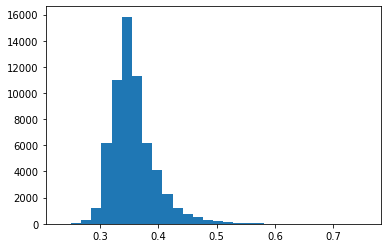

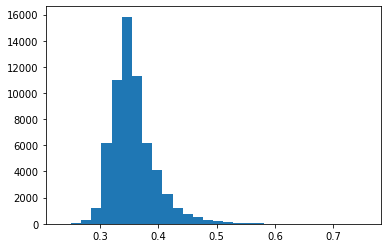

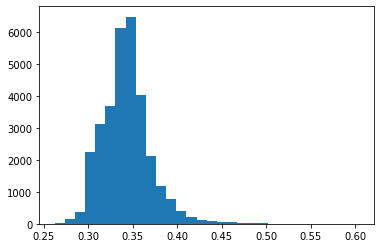

In [22]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [23]:
df_train['y_pred'] = train_pred
df_test['y_pred'] = test_pred

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

In [25]:
df_pred = pd.concat([df_train_pred, df_test_pred], axis=0)

In [26]:
df_index_sub = df_index.loc['1994':]

In [27]:
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short

In [28]:
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [29]:
strategy.set_rebalance_period(freq='week', rebalance_weekday=1) 

2019-10-31 08:56:31,584 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD


In [30]:
tester = Tester(strategy)

In [31]:
tsrv_cum_return, tsrv_summary = tester.test_ts_signal()
csrv_cum_return, csrv_summary = tester.test_cs_signal()

C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: divide by zero encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:29: RuntimeWarning: invalid value encountered in true_divide
  tsrv_port = pd.DataFrame(tsrv_sig.to_numpy() / tsrv_sig.sum(axis=1).values.reshape(-1, 1), columns=tsrv_sig.columns, index=tsrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: divide by zero encountered in true_divide
  csrv_port = pd.DataFrame(csrv_sig.to_numpy() / csrv_sig.sum(axis=1).values.reshape(-1, 1), columns=csrv_sig.columns, index=csrv_sig.index)
C:\Users\jungyoon.choi\Desktop\jungyoon\project\risk_premia\python\strategy\tester.py:39: RuntimeWarning: invalid value encountered in

In [32]:
strategy.set_portfolio_parameter(cs_strategy_type='notional')
strategy.make_portfolio()

2019-10-31 08:56:31,616 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 08:56:31,616 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 08:56:31,617 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 08:56:46,109 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 08:56:46,110 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 08:56:47,833 - EPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-31 08:56:47,840 - EPM - INFO - [STEP 5 - 2 - 3] STRATEGY LEVEL VOL CONTROL to TS POSITION
2019-10-31 08:56:49,009 - EPM - INFO - [STEP 5 - 2 - 4] MAKE FINAL TS POSITION
2019-10-31 08:56:49,012 - EPM - INFO - [STEP 5 - 3] MAKE CS POSITION
2019-10-31 08:56:49,013 - EPM - INFO - [STEP 5 - 3 - 1] NO TARGET VOL CONTROL to CS POSITION
2019-10-31 08:56:49,014 - EPM - INFO - [STEP 5 - 3 - 2] ALIGN CS POSITION WITH REBALANCE DAY
2019-10-31 08:56:59,199 - EPM - INFO - [STEP 5 - 3 - 3] STRATEGY LEVEL VOL CONTROL to CS POSITION
2019-10-31

### TRAIN

2019-10-31 08:57:00,705 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:57:00,706 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:57:00,714 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:57:00,722 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


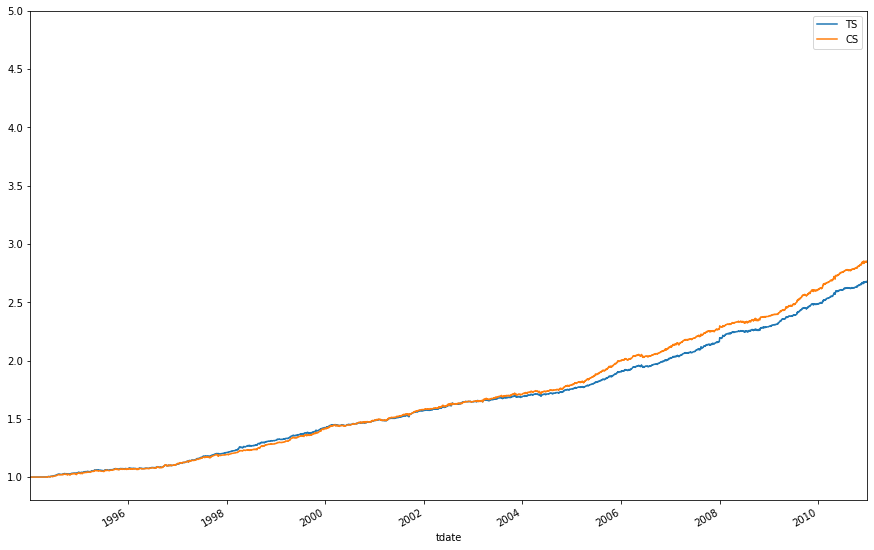

In [33]:
tester = Tester(strategy)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.8, 5))

### TEST

2019-10-31 08:57:00,882 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:57:00,883 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:57:00,890 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:57:00,897 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


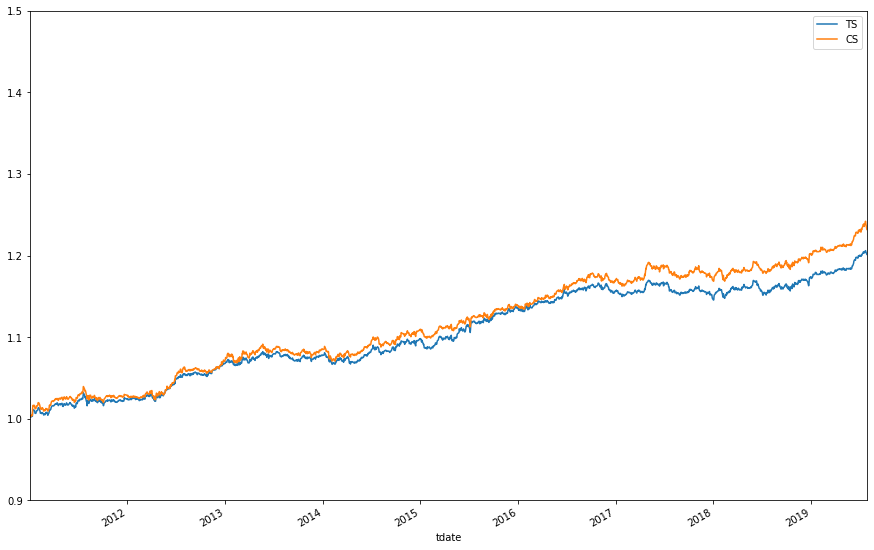

In [34]:
tester = Tester(strategy)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.5))

# CASE 2. BINARY 30% 70%


- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [35]:
one_week = 5
one_month = 20

df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

df_index_y_binary30_1 = df_index_rank > 7/10 * df_index_rank.shape[1]
df_index_y_binary30_1 = df_index_y_binary30_1.astype(np.float32)

df_index_y_binary30_2 = df_index_rank < 3/10 * df_index_rank.shape[1]
df_index_y_binary30_2 = df_index_y_binary30_2.astype(np.float32)

In [36]:
df_index_y_binary30_1 = df_index_y_binary30_1.unstack().reset_index()
df_index_y_binary30_1.columns = ['ticker', 'tdate', 'info']

df_index_y_binary30_2 = df_index_y_binary30_2.unstack().reset_index()
df_index_y_binary30_2.columns = ['ticker', 'tdate', 'info']

In [37]:
df_index_y_binary30_1 = df_index_y_binary30_1[df_index_y_binary30_1['info'] == 1]
df_index_y_binary30_2 = df_index_y_binary30_2[df_index_y_binary30_2['info'] == 1]
df_index_y_binary30 = pd.concat([df_index_y_binary30_1, df_index_y_binary30_2], axis=0)

In [38]:
df_y2 = df_index_y_binary.unstack().reset_index()
df_y2.columns = ['ticker', 'tdate', 'y']
df_y2 = pd.merge(df_y2, df_index_y_binary30, on=['ticker', 'tdate'])

In [39]:
df_join2 = pd.merge(df_y2, df_moving_avg, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_moving_avg_ratio_diff, on=['tdate', 'ticker'])

In [40]:
df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[4:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [41]:
model2, train_pred2, val_pred2 = train(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.686167	valid_1's binary_logloss: 0.729901
[20]	training's binary_logloss: 0.685484	valid_1's binary_logloss: 0.729288
[30]	training's binary_logloss: 0.684884	valid_1's binary_logloss: 0.728874
[40]	training's binary_logloss: 0.684347	valid_1's binary_logloss: 0.728468
[50]	training's binary_logloss: 0.683858	valid_1's binary_logloss: 0.728196
[60]	training's binary_logloss: 0.68339	valid_1's binary_logloss: 0.727831
[70]	training's binary_logloss: 0.682957	valid_1's binary_logloss: 0.727484
[80]	training's binary_logloss: 0.682559	valid_1's binary_logloss: 0.727136
[90]	training's binary_logloss: 0.682191	valid_1's binary_logloss: 0.726797
[100]	training's binary_logloss: 0.68186	valid_1's binary_logloss: 0.726589
[110]	training's binary_logloss: 0.681546	valid_1's binary_logloss: 0.726356
[120]	training's binary_logloss: 0.681213	valid_1's binary_logloss: 0.726194
[130]	training's binary_l

In [42]:
df_pred2 = df_join.copy()
pred2 = model2.predict(df_join[df_join.columns[3:]].values)
df_pred2['y_pred'] = pred2
df_pred2 = pd.pivot_table(df_pred2, columns='ticker', index='tdate', values='y_pred')

(array([1.8000e+01, 5.9000e+01, 1.2700e+02, 2.8400e+02, 4.7200e+02,
        8.3000e+02, 2.7300e+03, 5.7810e+03, 7.2740e+03, 1.1209e+04,
        1.7622e+04, 1.8012e+04, 1.4698e+04, 7.6170e+03, 2.7200e+03,
        1.2260e+03, 8.7300e+02, 5.3500e+02, 4.2000e+02, 3.4400e+02,
        1.8500e+02, 5.1000e+01, 3.1000e+01, 1.1000e+01, 3.0000e+00,
        3.0000e+00, 1.9000e+01, 1.0000e+01, 1.0000e+01, 1.0000e+01]),
 array([0.36663142, 0.38366639, 0.40070136, 0.41773633, 0.4347713 ,
        0.45180627, 0.46884123, 0.4858762 , 0.50291117, 0.51994614,
        0.53698111, 0.55401608, 0.57105105, 0.58808602, 0.60512099,
        0.62215596, 0.63919093, 0.6562259 , 0.67326087, 0.69029584,
        0.70733081, 0.72436578, 0.74140075, 0.75843572, 0.77547068,
        0.79250565, 0.80954062, 0.82657559, 0.84361056, 0.86064553,
        0.8776805 ]),
 <a list of 30 Patch objects>)

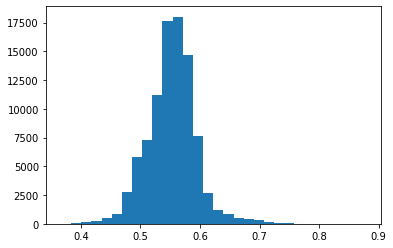

In [43]:
plt.hist(pred2, bins=30)

In [44]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3

df_pred_rank2 = df_pred2.rank(axis=1)

df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [45]:
strategy2 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy2.load_index_and_return(from_db=False, save_file=False)

strategy2.index.columns.name = 'ticker'
strategy2.ret.columns.name = 'ticker'

strategy2.index.index.name = 'tdate'
strategy2.ret.index.name = 'tdate'

strategy2.index.drop_duplicates(inplace=True)
strategy2.ret.drop_duplicates(inplace=True)

strategy2.ret.loc['2005-02-16'] = strategy.ret.loc['2005-02-17']

df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

2019-10-31 08:57:03,115 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 08:57:03,115 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 08:57:03,117 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 08:57:03,117 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 08:57:03,118 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 08:57:03,118 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [46]:
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2

strategy2.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy2.set_portfolio_parameter(cs_strategy_type='notional')
strategy2.make_portfolio()

2019-10-31 08:57:03,168 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 08:57:03,168 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 08:57:03,169 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 08:57:03,169 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 08:57:03,170 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 08:57:03,170 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 08:57:03,172 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 08:57:03,172 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 08:57:19,800 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 08:57:19,800 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 08:57:19,801 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 08:57:19,801 - EPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2019-10-31 08:57:21,580 - EPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2019-10-31 08:57:21,580 - EPM - 

### TRAIN

2019-10-31 08:57:37,189 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:57:37,189 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:57:37,190 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:57:37,190 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:57:37,202 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:57:37,202 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:57:37,214 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 08:57:37,214 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


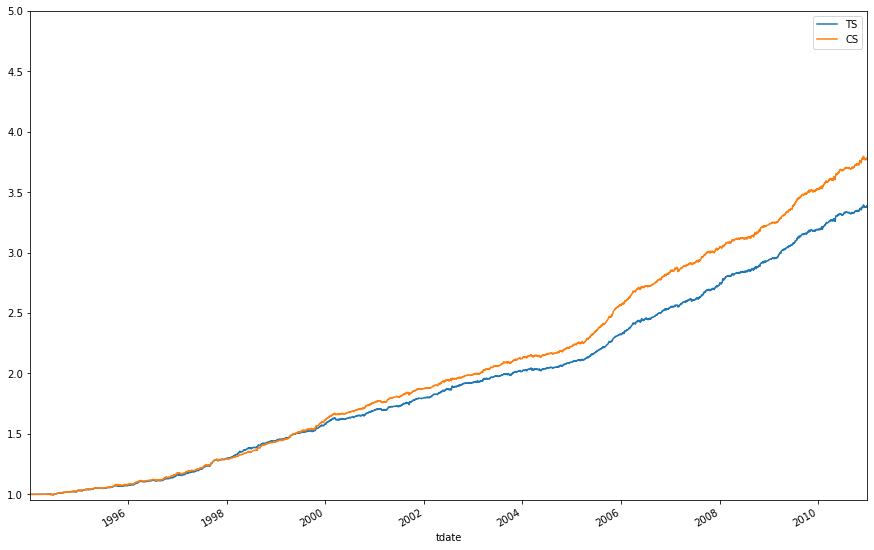

In [47]:
tester = Tester(strategy2)
tester.set_period(start='1994-01-01', end='2010-12-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.95, 5))

### TEST

2019-10-31 08:57:37,480 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:57:37,480 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:57:37,482 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:57:37,482 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:57:37,493 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:57:37,493 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:57:37,504 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 08:57:37,504 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


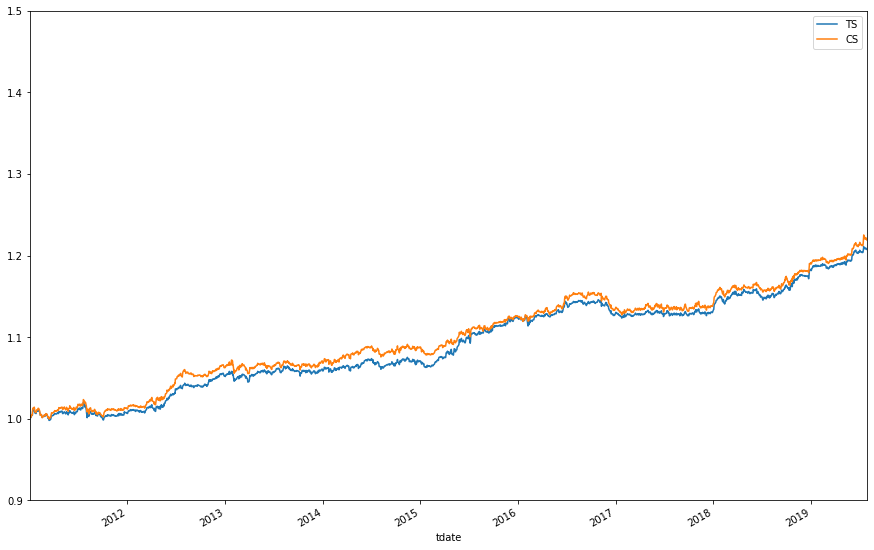

In [48]:
tester = Tester(strategy2)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.5))

# CASE 3. Case1을 Rolling으로 실행

In [49]:
rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [50]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [51]:
models = []
train_preds = []
test_preds = []

In [52]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.651195	valid_1's binary_logloss: 0.651455
[20]	training's binary_logloss: 0.65069	valid_1's binary_logloss: 0.651192
[30]	training's binary_logloss: 0.650243	valid_1's binary_logloss: 0.650929
[40]	training's binary_logloss: 0.649834	valid_1's binary_logloss: 0.65074
[50]	training's binary_logloss: 0.649463	valid_1's binary_logloss: 0.650609
[60]	training's binary_logloss: 0.649119	valid_1's binary_logloss: 0.650515
[70]	training's binary_logloss: 0.648801	valid_1's binary_logloss: 0.650415
[80]	training's binary_logloss: 0.648516	valid_1's binary_logloss: 0.650323
[90]	training's binary_logloss: 0.648237	valid_1's binary_logloss: 0.650269
[100]	training's binary_logloss: 0.647978	valid_1's binary_logloss: 0.650199
[110]	training's binary_logloss: 0.647732	valid_1's binary_logloss: 0.650117
[120]	training's binary_logloss: 0.6475	valid_1's binary_logloss: 0.650056
[130]	training's binary_log

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.651204	valid_1's binary_logloss: 0.651407
[20]	training's binary_logloss: 0.650714	valid_1's binary_logloss: 0.651108
[30]	training's binary_logloss: 0.650284	valid_1's binary_logloss: 0.650866
[40]	training's binary_logloss: 0.649904	valid_1's binary_logloss: 0.650659
[50]	training's binary_logloss: 0.649575	valid_1's binary_logloss: 0.650506
[60]	training's binary_logloss: 0.649254	valid_1's binary_logloss: 0.650427
[70]	training's binary_logloss: 0.648953	valid_1's binary_logloss: 0.650395
[80]	training's binary_logloss: 0.64868	valid_1's binary_logloss: 0.650338
[90]	training's binary_logloss: 0.64842	valid_1's binary_logloss: 0.650292
[100]	training's binary_logloss: 0.648173	valid_1's binary_logloss: 0.650224
[110]	training's binary_logloss: 0.647946	valid_1's binary_logloss: 0.650157
[120]	training's binary_logloss: 0.647724	valid_1's binary_logloss: 0.650103
[130]	training's binary_l

[60]	training's binary_logloss: 0.649335	valid_1's binary_logloss: 0.650891
[70]	training's binary_logloss: 0.649038	valid_1's binary_logloss: 0.650764
[80]	training's binary_logloss: 0.64877	valid_1's binary_logloss: 0.650641
[90]	training's binary_logloss: 0.648519	valid_1's binary_logloss: 0.650564
[100]	training's binary_logloss: 0.648295	valid_1's binary_logloss: 0.650548
[110]	training's binary_logloss: 0.648075	valid_1's binary_logloss: 0.650491
[120]	training's binary_logloss: 0.647858	valid_1's binary_logloss: 0.650394
[130]	training's binary_logloss: 0.647637	valid_1's binary_logloss: 0.650348
[140]	training's binary_logloss: 0.647446	valid_1's binary_logloss: 0.650313
[150]	training's binary_logloss: 0.647252	valid_1's binary_logloss: 0.650257
[160]	training's binary_logloss: 0.647047	valid_1's binary_logloss: 0.650206
[170]	training's binary_logloss: 0.646863	valid_1's binary_logloss: 0.65018
[180]	training's binary_logloss: 0.646663	valid_1's binary_logloss: 0.650145
[190]

[130]	training's binary_logloss: 0.647899	valid_1's binary_logloss: 0.649748
[140]	training's binary_logloss: 0.647714	valid_1's binary_logloss: 0.64972
[150]	training's binary_logloss: 0.647537	valid_1's binary_logloss: 0.64971
[160]	training's binary_logloss: 0.647364	valid_1's binary_logloss: 0.649666
[170]	training's binary_logloss: 0.647176	valid_1's binary_logloss: 0.64967
[180]	training's binary_logloss: 0.646996	valid_1's binary_logloss: 0.649664
[190]	training's binary_logloss: 0.646825	valid_1's binary_logloss: 0.649676
[200]	training's binary_logloss: 0.646668	valid_1's binary_logloss: 0.64969
[210]	training's binary_logloss: 0.646503	valid_1's binary_logloss: 0.649697
[220]	training's binary_logloss: 0.646353	valid_1's binary_logloss: 0.649704
[230]	training's binary_logloss: 0.646205	valid_1's binary_logloss: 0.649728
[240]	training's binary_logloss: 0.646044	valid_1's binary_logloss: 0.64973
[250]	training's binary_logloss: 0.645886	valid_1's binary_logloss: 0.649734
[260

[180]	training's binary_logloss: 0.647359	valid_1's binary_logloss: 0.6486
[190]	training's binary_logloss: 0.647199	valid_1's binary_logloss: 0.648499
[200]	training's binary_logloss: 0.64706	valid_1's binary_logloss: 0.648459
[210]	training's binary_logloss: 0.646912	valid_1's binary_logloss: 0.648428
[220]	training's binary_logloss: 0.646783	valid_1's binary_logloss: 0.648399
[230]	training's binary_logloss: 0.646646	valid_1's binary_logloss: 0.648388
[240]	training's binary_logloss: 0.646494	valid_1's binary_logloss: 0.648365
[250]	training's binary_logloss: 0.646354	valid_1's binary_logloss: 0.648364
[260]	training's binary_logloss: 0.646221	valid_1's binary_logloss: 0.648346
[270]	training's binary_logloss: 0.646071	valid_1's binary_logloss: 0.648282
[280]	training's binary_logloss: 0.645934	valid_1's binary_logloss: 0.648245
[290]	training's binary_logloss: 0.64579	valid_1's binary_logloss: 0.648181
[300]	training's binary_logloss: 0.645651	valid_1's binary_logloss: 0.648137
[31

In [53]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

(array([9.000e+00, 1.700e+01, 6.100e+01, 1.900e+02, 1.330e+03, 3.573e+03,
        5.730e+03, 6.461e+03, 5.423e+03, 3.507e+03, 2.065e+03, 1.151e+03,
        7.670e+02, 4.180e+02, 2.260e+02, 1.200e+02, 7.100e+01, 6.100e+01,
        2.900e+01, 3.100e+01, 1.600e+01, 9.000e+00, 6.000e+00, 3.000e+00,
        2.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 4.000e+00]),
 array([0.25314852, 0.26490006, 0.27665159, 0.28840313, 0.30015466,
        0.31190619, 0.32365773, 0.33540926, 0.3471608 , 0.35891233,
        0.37066386, 0.3824154 , 0.39416693, 0.40591847, 0.41767   ,
        0.42942154, 0.44117307, 0.4529246 , 0.46467614, 0.47642767,
        0.48817921, 0.49993074, 0.51168228, 0.52343381, 0.53518534,
        0.54693688, 0.55868841, 0.57043995, 0.58219148, 0.59394302,
        0.60569455]),
 <a list of 30 Patch objects>)

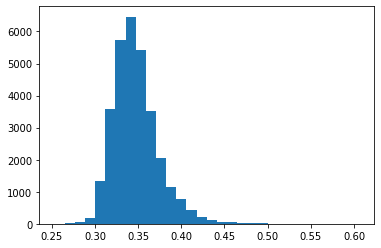

In [54]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [55]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [56]:
strategy3 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy3.load_index_and_return(from_db=False, save_file=False)

strategy3.index.columns.name = 'ticker'
strategy3.ret.columns.name = 'ticker'

strategy3.index.index.name = 'tdate'
strategy3.ret.index.name = 'tdate'

strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

strategy3.ret.loc['2005-02-16'] = strategy.ret.loc['2005-02-17']

df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

2019-10-31 08:58:00,404 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 08:58:00,404 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 08:58:00,404 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 08:58:00,406 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 08:58:00,406 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 08:58:00,406 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 08:58:00,407 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 08:58:00,407 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 08:58:00,407 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [57]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy3.set_portfolio_parameter(cs_strategy_type='notional')
strategy3.make_portfolio()

2019-10-31 08:58:00,453 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 08:58:00,453 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 08:58:00,453 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 08:58:00,455 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 08:58:00,455 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 08:58:00,455 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 08:58:00,456 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 08:58:00,456 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 08:58:00,456 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 08:58:00,457 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 08:58:00,457 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 08:58:00,457 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 08:58:17,641 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 08:58:17,641 - EPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2019-10-31 08:58:17,641 - EPM -

2019-10-31 08:58:24,912 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:58:24,912 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:58:24,912 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:58:24,914 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:58:24,914 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:58:24,914 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:58:24,926 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:58:24,926 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:58:24,926 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:58:24,938 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 08:58:24,938 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 08:58:24,938 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT


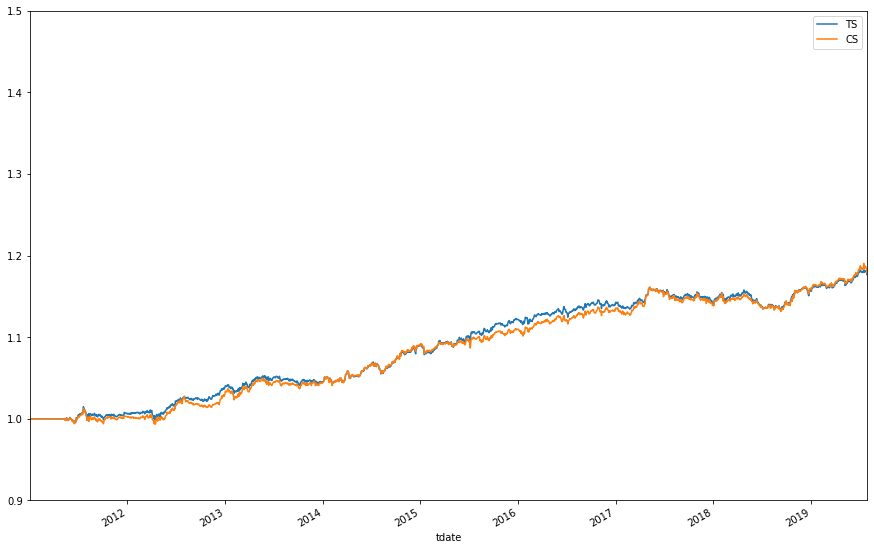

In [58]:
tester = Tester(strategy3)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False, ylim=(0.9, 1.5))

# CASE 4. CASE 2를 ROLLING으로 실행

In [59]:
models = []
train_preds = []
test_preds = []

In [60]:
for i, one_year in enumerate(rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(rolling_one_year[i])]
    
    if i == len(rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(rolling_one_year[i])]
    else:
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, test_pred = train(df_train_x.values, df_train_y.values, df_test_x.values, df_test_y.values, 
                                        num_boost_round=500, 
                                        learning_rate=0.01, 
                                        verbose=10,
                                        early_stopping_rounds=500)
    
    df_train['y_pred'] = train_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    test_preds.append(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.686167	valid_1's binary_logloss: 0.73132
[20]	training's binary_logloss: 0.685484	valid_1's binary_logloss: 0.731168
[30]	training's binary_logloss: 0.684884	valid_1's binary_logloss: 0.731448
[40]	training's binary_logloss: 0.684347	valid_1's binary_logloss: 0.731687
[50]	training's binary_logloss: 0.683858	valid_1's binary_logloss: 0.731898
[60]	training's binary_logloss: 0.68339	valid_1's binary_logloss: 0.731806
[70]	training's binary_logloss: 0.682957	valid_1's binary_logloss: 0.731787
[80]	training's binary_logloss: 0.682559	valid_1's binary_logloss: 0.73196
[90]	training's binary_logloss: 0.682191	valid_1's binary_logloss: 0.731898
[100]	training's binary_logloss: 0.68186	valid_1's binary_logloss: 0.732185
[110]	training's binary_logloss: 0.681546	valid_1's binary_logloss: 0.732266
[120]	training's binary_logloss: 0.681213	valid_1's binary_logloss: 0.732486
[130]	training's binary_log

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.686206	valid_1's binary_logloss: 0.729881
[20]	training's binary_logloss: 0.685535	valid_1's binary_logloss: 0.72881
[30]	training's binary_logloss: 0.684946	valid_1's binary_logloss: 0.727839
[40]	training's binary_logloss: 0.684432	valid_1's binary_logloss: 0.727096
[50]	training's binary_logloss: 0.683966	valid_1's binary_logloss: 0.726589
[60]	training's binary_logloss: 0.683531	valid_1's binary_logloss: 0.726058
[70]	training's binary_logloss: 0.683117	valid_1's binary_logloss: 0.725371
[80]	training's binary_logloss: 0.68273	valid_1's binary_logloss: 0.724832
[90]	training's binary_logloss: 0.68237	valid_1's binary_logloss: 0.724033
[100]	training's binary_logloss: 0.682041	valid_1's binary_logloss: 0.723585
[110]	training's binary_logloss: 0.681735	valid_1's binary_logloss: 0.723099
[120]	training's binary_logloss: 0.681434	valid_1's binary_logloss: 0.722284
[130]	training's binary_lo

[30]	training's binary_logloss: 0.68506	valid_1's binary_logloss: 0.728696
[40]	training's binary_logloss: 0.68457	valid_1's binary_logloss: 0.728161
[50]	training's binary_logloss: 0.684113	valid_1's binary_logloss: 0.727579
[60]	training's binary_logloss: 0.683713	valid_1's binary_logloss: 0.726818
[70]	training's binary_logloss: 0.683335	valid_1's binary_logloss: 0.726076
[80]	training's binary_logloss: 0.68299	valid_1's binary_logloss: 0.725605
[90]	training's binary_logloss: 0.682632	valid_1's binary_logloss: 0.724806
[100]	training's binary_logloss: 0.682305	valid_1's binary_logloss: 0.724459
[110]	training's binary_logloss: 0.682003	valid_1's binary_logloss: 0.723944
[120]	training's binary_logloss: 0.681729	valid_1's binary_logloss: 0.72358
[130]	training's binary_logloss: 0.681448	valid_1's binary_logloss: 0.723393
[140]	training's binary_logloss: 0.6812	valid_1's binary_logloss: 0.723101
[150]	training's binary_logloss: 0.680953	valid_1's binary_logloss: 0.722746
[160]	traini

[90]	training's binary_logloss: 0.682968	valid_1's binary_logloss: 0.728415
[100]	training's binary_logloss: 0.682693	valid_1's binary_logloss: 0.72856
[110]	training's binary_logloss: 0.682395	valid_1's binary_logloss: 0.728295
[120]	training's binary_logloss: 0.682117	valid_1's binary_logloss: 0.728057
[130]	training's binary_logloss: 0.681859	valid_1's binary_logloss: 0.727994
[140]	training's binary_logloss: 0.681618	valid_1's binary_logloss: 0.727887
[150]	training's binary_logloss: 0.681379	valid_1's binary_logloss: 0.72792
[160]	training's binary_logloss: 0.681155	valid_1's binary_logloss: 0.727749
[170]	training's binary_logloss: 0.680942	valid_1's binary_logloss: 0.727674
[180]	training's binary_logloss: 0.680725	valid_1's binary_logloss: 0.726729
[190]	training's binary_logloss: 0.680506	valid_1's binary_logloss: 0.72568
[200]	training's binary_logloss: 0.680278	valid_1's binary_logloss: 0.7256
[210]	training's binary_logloss: 0.680079	valid_1's binary_logloss: 0.725479
[220]

[140]	training's binary_logloss: 0.68208	valid_1's binary_logloss: 0.727931
[150]	training's binary_logloss: 0.681865	valid_1's binary_logloss: 0.728061
[160]	training's binary_logloss: 0.681664	valid_1's binary_logloss: 0.728156
[170]	training's binary_logloss: 0.68147	valid_1's binary_logloss: 0.728167
[180]	training's binary_logloss: 0.681278	valid_1's binary_logloss: 0.728192
[190]	training's binary_logloss: 0.681086	valid_1's binary_logloss: 0.728289
[200]	training's binary_logloss: 0.680896	valid_1's binary_logloss: 0.728235
[210]	training's binary_logloss: 0.680701	valid_1's binary_logloss: 0.728343
[220]	training's binary_logloss: 0.680518	valid_1's binary_logloss: 0.728221
[230]	training's binary_logloss: 0.680343	valid_1's binary_logloss: 0.728081
[240]	training's binary_logloss: 0.680155	valid_1's binary_logloss: 0.728085
[250]	training's binary_logloss: 0.679963	valid_1's binary_logloss: 0.728008
[260]	training's binary_logloss: 0.679773	valid_1's binary_logloss: 0.728049
[

In [61]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [62]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [63]:
strategy4 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy4.load_index_and_return(from_db=False, save_file=False)

strategy4.index.columns.name = 'ticker'
strategy4.ret.columns.name = 'ticker'

strategy4.index.index.name = 'tdate'
strategy4.ret.index.name = 'tdate'

strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

strategy4.ret.loc['2005-02-16'] = strategy.ret.loc['2005-02-17']

df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

2019-10-31 08:58:50,470 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 08:58:50,470 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 08:58:50,470 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 08:58:50,470 - EPM - INFO - [STEP 0] START LOGGING EPM
2019-10-31 08:58:50,473 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 08:58:50,473 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 08:58:50,473 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 08:58:50,473 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-31 08:58:50,475 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 08:58:50,475 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 08:58:50,475 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE
2019-10-31 08:58:50,475 - EPM - INFO - [STEP 1 - 1] LOAD DATA FROM FILE


In [64]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='week', rebalance_weekday=1) 
strategy4.set_portfolio_parameter(cs_strategy_type='notional')
strategy4.make_portfolio()

2019-10-31 08:58:50,555 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 08:58:50,555 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 08:58:50,555 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 08:58:50,555 - EPM - INFO - [STEP 2] SET REBALANCE PERIOD
2019-10-31 08:58:50,557 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 08:58:50,557 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 08:58:50,557 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 08:58:50,557 - EPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2019-10-31 08:58:50,559 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 08:58:50,559 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 08:58:50,559 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 08:58:50,559 - EPM - INFO - [STEP 5] MAKE PORTFOLIO
2019-10-31 08:58:50,561 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 08:58:50,561 - EPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2019-10-31 08:58:50,561 - EPM - INFO -

2019-10-31 08:59:17,746 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:59:17,746 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:59:17,746 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:59:17,746 - EPM - INFO - [STEP 6] START BACKTEST
2019-10-31 08:59:17,748 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:59:17,748 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:59:17,748 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:59:17,748 - EPM - INFO - [STEP 6 - 1] BACKTEST EPM TIME SERIES
2019-10-31 08:59:17,756 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:59:17,756 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:59:17,756 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:59:17,756 - EPM - INFO - [STEP 6 - 2] BACKTEST EPM CROSS SECTIONAL
2019-10-31 08:59:17,764 - EPM - INFO - [STEP 7] PLOT BACKTEST RESULT
2019-10-31 08:59:17,764 - EPM - INFO - [STEP 7]

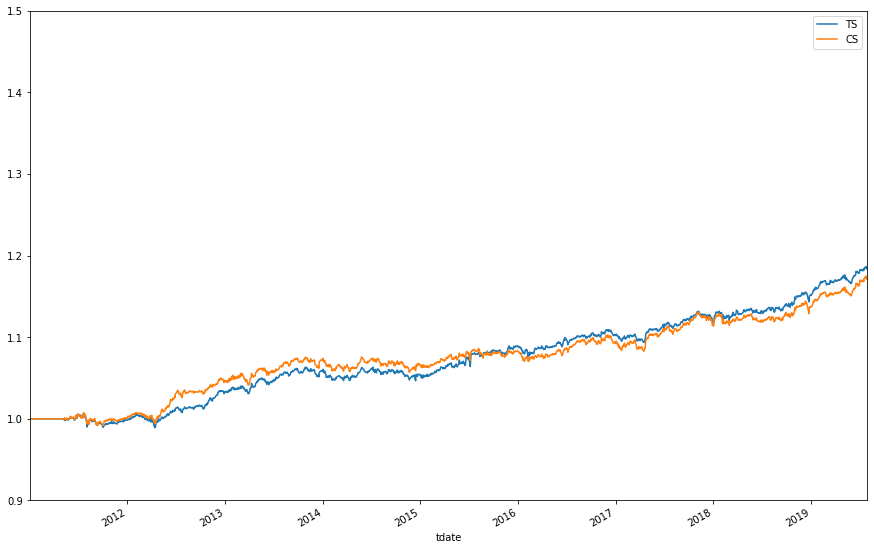

In [65]:
tester = Tester(strategy4)
tester.set_period(start='2011-01-01', end='2019-07-31')
tester.run(save_file=False)
tester.plot_result(save_file=False,  ylim=(0.9, 1.5))